# Check GPU Usage

In [1]:
!nvidia-smi

Wed Oct 05 15:14:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080   WDDM  | 00000000:01:00.0  On |                  N/A |
| 27%   38C    P8    12W / 180W |    947MiB /  8192MiB |     11%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

# Import Pytorch Package

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os

if torch.cuda.is_available():
    train_on_gpu = True
else:
    train_on_gpu = False

print(torch.__version__)

1.10.1


In [3]:
#Run this if an error occured
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Load Dataset

In [4]:
from torch.utils.data import Dataset
from torchvision import transforms

class LoadDataset(Dataset):
    
    def __init__(self, root_dir, color_mode=None, preprocessing=None, mode=None):
        """
        Args:
            root_dir(str): Path to target image folder.
                Classification mode should contain atleast one subdirectory per class.
                Still working on segmentation and object detection mode.
            color_mode(str):
                Color mode of input image.
                RGB, RGBA, BGR,etc.
            preprocessing(callable, optional): Preprocessing that would be applied on image
        """
        self.root_dir = root_dir
        self.preprocessing = preprocessing
        self.color_mode = color_mode
        #self.mode = mode
        
        self.class_names = [f for f in os.listdir(root_dir) if not f.startswith('.')]
        self.img_names = []
        self.labels = []
        
        for i in range(len(self.class_names)):
            class_dir = os.path.join(self.root_dir, self.class_names[i])
            img_list = os.listdir(class_dir)
            img_list = [class_dir
                + os.sep
                + f for f in img_list if not f.startswith('.')]
            self.img_names += img_list
            self.labels += [i for _ in range(len(img_list))]
            
        print(len(self.img_names),
             "images belong to",
             len(self.class_names),
             "class")
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_names[idx])
        if self.color_mode is not None:
            img = img.convert(self.color_mode)
        
        if self.preprocessing is not None:
            img = self.preprocessing(img)
            
        label = self.labels[idx]
        return img, label
        
        
        

C:\Users\HuangSH\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\HuangSH\anaconda3\envs\pytorch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [5]:
from torchvision import transforms

preprocessing = transforms.Compose([
    transforms.Resize((224,224)),
])

# Image Cropping

In [6]:
retina_dataset = LoadDataset(
   "Test_LR",
    color_mode="RGB",
    preprocessing=preprocessing,
)

8 images belong to 2 class


Image before cropping

Class: Left


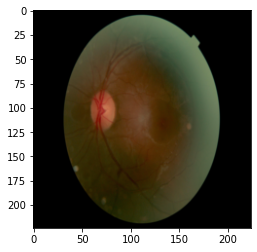

In [7]:
imgs, labels = retina_dataset[0]

plt.imshow(imgs)

print("Class:", retina_dataset.class_names[labels])


In [8]:
def clipcircle(dataset,upper_limit, down_limit,resize_shape):
    clipped_dataset = []
    for i in tqdm(range(0,len(dataset))):
        image, label = dataset[i]
        image = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR)
        original_image = image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        canny = cv2.Canny(blurred, upper_limit, down_limit)
        contours, hierarchy= cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
        for (j,c) in enumerate(sorted_contours):
            if j == 1:
                break
            else:
                x,y,w,h= cv2.boundingRect(c)
                cropped_contour= original_image[y:y+h, x:x+w]


        new_image = cv2.resize(cropped_contour, (resize_shape,resize_shape), interpolation=cv2.INTER_AREA)
        rows, cols, channel = new_image.shape


        img_new = np.zeros((rows,cols,4),np.uint8)
        img_new[:,:,0:3] = new_image[:,:,0:3]


        img_circle = np.zeros((rows,cols,1),np.uint8)
        img_circle[:,:,:] = 0  
        img_circle = cv2.circle(img_circle,(int(cols/2),int(rows/2)),int(min(rows, cols)/2),(255),-1) 

            # 圖片融合
        img_new[:,:,3] = img_circle[:,:,0]

        img_new = Image.fromarray(cv2.cvtColor(img_new,cv2.COLOR_BGRA2RGBA))
        
        clipped_dataset.append((img_new, label))
        
    clipped_dataset = tuple(clipped_dataset)
    
    return clipped_dataset

In [9]:
clip_dataset = clipcircle(retina_dataset, 10, 120, 224)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.97it/s]


Example of Cropped Image

Class: Left


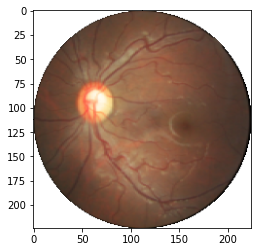

In [10]:
clipped_img, labels = clip_dataset[3]

plt.imshow(clipped_img)
print("Class:", retina_dataset.class_names[labels])

# Enhancement

In [11]:
def luminosity(dataset):
    lumino_dataset = []
    for i in tqdm(range(0,len(dataset))):
        
        image, label = dataset[i]
        image = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGBA2BGRA)
        
        r  = image[:,:,0]*0.21
        g  = image[:,:,1]*0.72
        b  = image[:,:,2]*0.07
        a  = image[:,:,3]
        r = np.array(r, dtype='uint8')
        g = np.array(g, dtype='uint8')
        b = np.array(b, dtype='uint8')
        g = r + g + b
        
        lumino_image = cv2.merge((g,g,g,a))
        lumino_image = Image.fromarray(cv2.cvtColor(lumino_image, cv2.COLOR_BGRA2RGBA))
        
        lumino_dataset.append((lumino_image, label))
        
    lumino_dataset = tuple(lumino_dataset)
    
    return lumino_dataset
        

In [12]:
lumino_dataset = luminosity(clip_dataset)

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1599.12it/s]


In [13]:
def clahe(dataset):
    clahe_dataset = []
    CLAHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for i in tqdm(range(0,len(dataset))):
        
        image, label = dataset[i]
        image = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGBA2BGRA)
        r = CLAHE.apply(image[:,:,0])
        g = CLAHE.apply(image[:,:,1])
        b = CLAHE.apply(image[:,:,2])
        a = image[:,:,3]
        clahe_image = cv2.merge((r,g,b,a))
        
        clahe_dataset.append((clahe_image, label))
    
    clahe_dataset = tuple(clahe_dataset)
    
    return clahe_dataset

In [14]:
lumino_clahe = clahe(lumino_dataset)

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1333.17it/s]


In [15]:
def retensor(dataset):
    retina_dataset = []
    for i in tqdm(range(0,len(dataset))):
        
        img, label = dataset[i]
        img_shape = transforms.ToTensor()(img)
        channel_num = img_shape.shape
        
        img = transforms.ToTensor()(img)
        
        
        retina_dataset.append((img, label))
        
    retina_dataset = tuple(retina_dataset)
    
    return retina_dataset

In [16]:
lumino_clahe = retensor(lumino_clahe)

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1599.28it/s]


# Classify Left or Right Eye

In [17]:
from torch.utils.data import DataLoader

test_loader = DataLoader(lumino_clahe, batch_size=4, shuffle=False, num_workers=0)

In [18]:
#@title Define prediction function
import sys

def predict(model, test_loader, from_logit=True, train_on_gpu=False, verbose=2):
    n_batch = len(test_loader)
    if verbose==2:
        iterator = tqdm(test_loader, file=sys.stdout)
    else:
        iterator = test_loader
    model.eval()

    prediction = []
    groudtruth = []
    batch_i = 1
    with torch.no_grad():
        for img, label in iterator:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                img, label = img.cuda(), label.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(img)
            prediction.append(output)
            groudtruth.append(label)

            if verbose==1:
                print("\rtest - batch: {:d}/{:d} | {:.2%}"
                    .format(batch_i, n_batch, batch_i/n_batch), end='')
                if batch_i == n_batch:
                    print()
            elif verbose==2:
                iterator.set_description("test")
            batch_i += 1
    prediction = torch.cat(prediction, axis=0)
    if from_logit:
        prediction = F.softmax(prediction, dim=-1)
    groudtruth = torch.cat(groudtruth, axis=0)

    return prediction, groudtruth

Model 1

In [19]:
import Resnet

In [20]:
model = Resnet.ResNet50(2, channels = 4)
model.load_state_dict(torch.load('Res50weight.pth'))
if train_on_gpu:
    model.cuda()

In [21]:
prediction, groudtruth = predict(
    model,
    test_loader,
    from_logit=False,
    train_on_gpu=train_on_gpu,
    verbose=2
    )

test: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


In [22]:
predicted_prob, predicted_class_indices = torch.max(prediction, dim=-1)

In [23]:
indices = torch.where(predicted_class_indices != 2)[0]

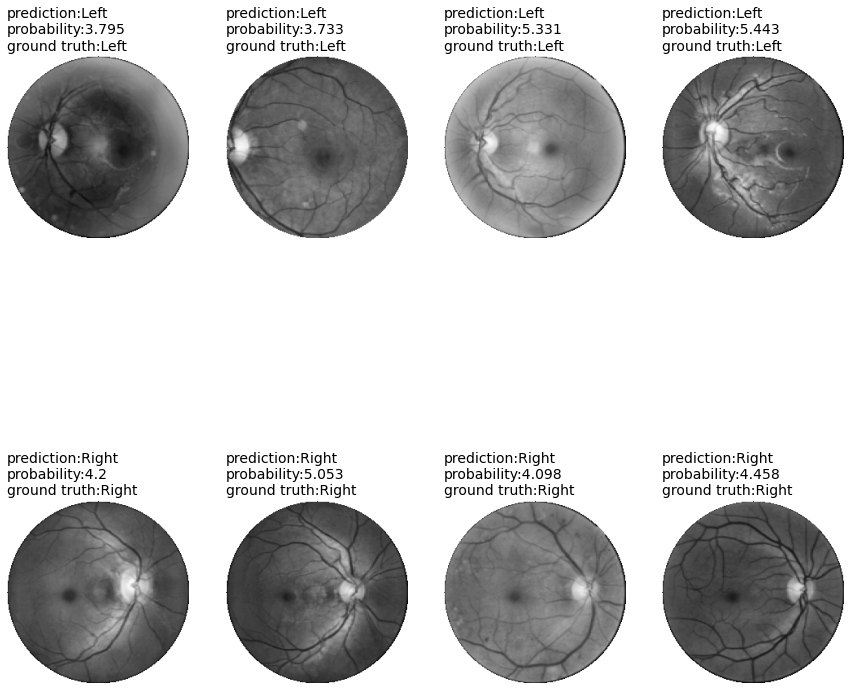

In [24]:
#@title Show all the hard examples
from math import ceil

rows = ceil(len(indices)/4)

plt.figure(figsize=(15, 15*ceil(rows/4)))
for i, w_idx in enumerate(indices):
    img, label = lumino_clahe[w_idx]
    pred = predicted_class_indices[w_idx]
    prob = round(predicted_prob[w_idx].item(), 3)

    ax = plt.subplot(rows, 4, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(
        "prediction:"
        + retina_dataset.class_names[pred]
        + "\nprobability:" + str(prob)
        + "\nground truth:"
        + retina_dataset.class_names[label],
        fontsize=14,
        loc="left")
    plt.axis("off")
plt.show()

Model 2

In [25]:
model = Resnet.ResNet101(2, channels = 4)
model.load_state_dict(torch.load('Res101weight.pth'))
if train_on_gpu:
    model.cuda()

In [26]:
prediction, groudtruth = predict(
    model,
    test_loader,
    from_logit=False,
    train_on_gpu=train_on_gpu,
    verbose=2
    )

test: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.36it/s]


In [27]:
predicted_prob, predicted_class_indices2 = torch.max(prediction, dim=-1)

In [28]:
indices = torch.where(predicted_class_indices != 2)[0]


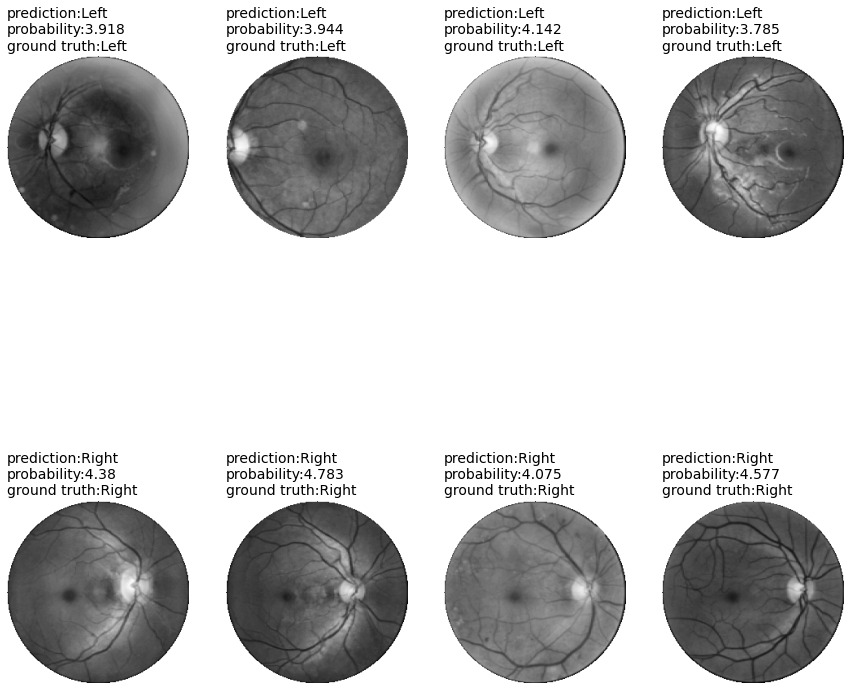

In [29]:
#@title Show all the hard examples
from math import ceil

rows = ceil(len(indices)/4)

plt.figure(figsize=(15, 15*ceil(rows/4)))
for i, w_idx in enumerate(indices):
    img, label = lumino_clahe[w_idx]
    pred = predicted_class_indices[w_idx]
    prob = round(predicted_prob[w_idx].item(), 3)

    ax = plt.subplot(rows, 4, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(
        "prediction:"
        + retina_dataset.class_names[pred]
        + "\nprobability:" + str(prob)
        + "\nground truth:"
        + retina_dataset.class_names[label],
        fontsize=14,
        loc="left")
    plt.axis("off")
plt.show()

Model 3

In [30]:
import Densenet

In [31]:
model = Densenet.DenseNet(block_config=(6, 12, 24, 16),num_classes=2)
model.load_state_dict(torch.load('Denseweight.pth'))
if train_on_gpu:
  model.cuda()

In [32]:
prediction, groudtruth = predict(
    model,
    test_loader,
    from_logit=False,
    train_on_gpu=train_on_gpu,
    verbose=2
    )

test: 100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 52.63it/s]


In [33]:
predicted_prob, predicted_class_indices3 = torch.max(prediction, dim=-1)

In [34]:
indices = torch.where(predicted_class_indices != 2)[0]

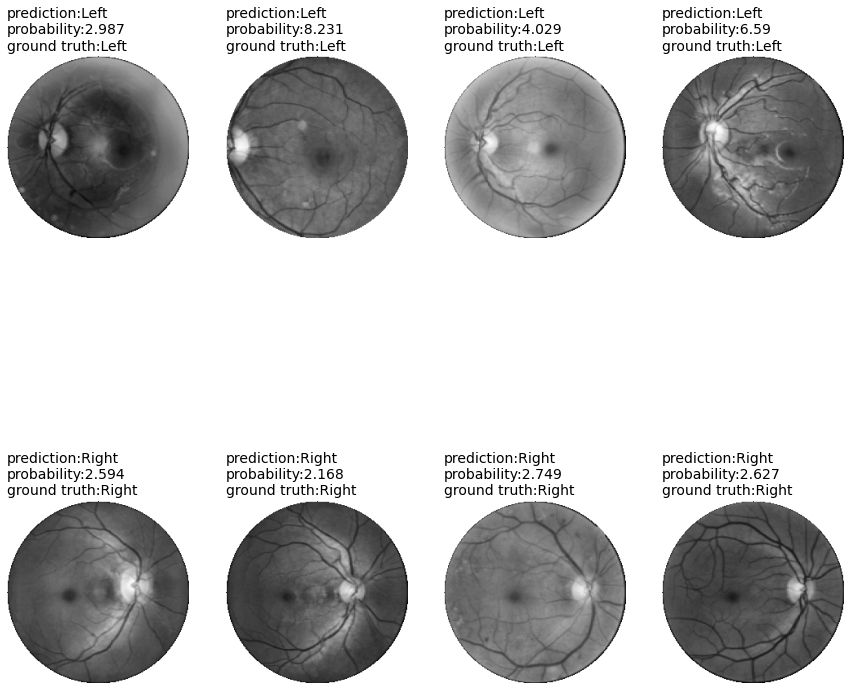

In [35]:
#@title Show all the hard examples
from math import ceil

rows = ceil(len(indices)/4)

plt.figure(figsize=(15, 15*ceil(rows/4)))
for i, w_idx in enumerate(indices):
    img, label = lumino_clahe[w_idx]
    pred = predicted_class_indices[w_idx]
    prob = round(predicted_prob[w_idx].item(), 3)

    ax = plt.subplot(rows, 4, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(
        "prediction:"
        + retina_dataset.class_names[pred]
        + "\nprobability:" + str(prob)
        + "\nground truth:"
        + retina_dataset.class_names[label],
        fontsize=14,
        loc="left")
    plt.axis("off")
plt.show()

In [43]:
final_prediction = []
for i in range(len(predicted_class_indices)):
    result = predicted_class_indices[i].item()+predicted_class_indices2[i].item()+predicted_class_indices3[i].item()
    if result == 0 or result == 1:
        final_prediction.append("Left")
    else:
        final_prediction.append("Right")

In [44]:
final_prediction

['Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right']